170498071/170498071 [==============================] - 4275s 25us/step


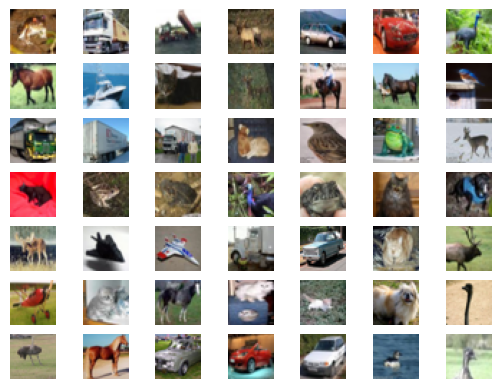

In [1]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
(trainX,trainy),(testX,testy) = load_data()
for i in range(49):
    pyplot.subplot(7,7,i+1)
    pyplot.axis('off')
    pyplot.imshow(trainX[i])
pyplot.show()

In [16]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Conv2D,Flatten,Dropout,LeakyReLU,Conv2DTranspose,Reshape
import numpy as np

In [3]:
# define the discriminator model
def define_desciminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64,(3,3),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [4]:
# define model
model = define_desciminator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         1

In [5]:
def load_real_samples():
    # (trainX,_),(_,_)=load_data()
    # convert to float
    X=trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X=(X-127.5)/127.5
    return X

In [6]:
X=load_real_samples()
X.shape

(50000, 32, 32, 3)

In [7]:
# select real samples
def generate_real_samples(dataset,n_samples):
    # choose random instances
    ix=np.random.randint(0,dataset.shape[0],n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples,1))
    return X,y

In [8]:
X,y = generate_real_samples(X,64)
print(X.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [9]:
def generate_fake_samples(n_samples):
    # generate uniform random samples in [0,1] which acts as fake image samples
    X = np.random.rand(32*32*3*n_samples)
    # update to have the range[-1,1]
    X = -1 + X*2
    # reshape into a batch of color images
    X = X.reshape((n_samples,32,32,3))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples,1))
    return X,y    

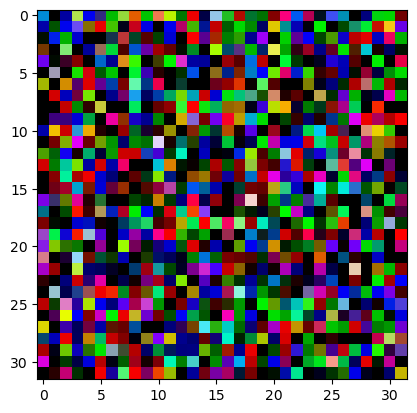

In [10]:
X,y=generate_fake_samples(64)
pyplot.imshow(X[0])

In [11]:
# train the discriminator model
def train_discriminator(model,dataset,n_iter=20,n_batch=128):
    half_batch = int(n_batch/2)
    # manually enumerate epcohs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real,y_real = generate_real_samples(dataset,half_batch)
        # update discriminator on real samples
        _,real_acc = model.train_on_batch(X_real,y_real)
        # generate 'fake' samples
        X_fake,y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _,fake_acc = model.train_on_batch(X_fake,y_fake)
        # summarize performance
        print('> %d real=%.0f%% fake=%.0f%% '% (i+1,real_acc*100,fake_acc*100))

In [12]:
model = define_desciminator()
dataset = load_real_samples()
train_discriminator(model,dataset)

> 1 real=94% fake=0% 
> 2 real=100% fake=0% 
> 3 real=98% fake=48% 
> 4 real=97% fake=100% 
> 5 real=94% fake=100% 
> 6 real=95% fake=100% 
> 7 real=98% fake=100% 
> 8 real=100% fake=100% 
> 9 real=98% fake=100% 
> 10 real=100% fake=100% 
> 11 real=100% fake=100% 
> 12 real=100% fake=100% 
> 13 real=100% fake=100% 
> 14 real=100% fake=100% 
> 15 real=100% fake=100% 
> 16 real=100% fake=100% 
> 17 real=100% fake=100% 
> 18 real=100% fake=100% 
> 19 real=100% fake=100% 
> 20 real=100% fake=100% 


In [18]:
# define the generator model
def define_generator(latent_dim):
    model=Sequential()
    # foundation for 4X4 image
    n_nodes = 4*4*256
    model.add(Dense(n_nodes,input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))
    # upsample to 8X8
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16X16
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32X32
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
    return model

In [19]:
# define the size of latent space
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                           

In [20]:
# generate points in latent space as input for generator
def generate_latent_points(latent_dim,n_samples):
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs of the network
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input

In [21]:
# use the generator to generate n fake samples , with class labels
def generate_fake_samples(g_model,latent_dim,n_samples):
    x_input = generate_latent_points(latent_dim,n_samples)
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples,1))
    return X,y

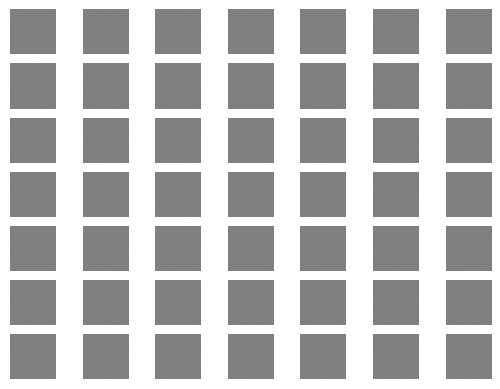

In [23]:
latent_dim =100
model = define_generator(latent_dim)
n_samples = 49
X,_ = generate_fake_samples(model,latent_dim,n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X+1) /2.0
# plot the generated samples
for i in range(n_samples):
    pyplot.subplot(7,7,i+1)
    pyplot.axis('off')
    pyplot.imshow(X[i])
pyplot.show()

In [25]:
# define the combined generator and discriminator model , for updating the generator
def define_gan(g_model,d_model):
    # make weights of the descriminator model non trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt= Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

In [26]:
latent_dim = 100
d_model = define_desciminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model,d_model)
gan_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_7 (Sequential)   (None, 1)                 372865    
                                                                 
Total params: 1838980 (7.02 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 372865 (1.42 MB)
_________________________________________________________________


In [29]:
# train the geneartor and descriminator
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=20,n_batch=128):
    batch_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(batch_per_epo):
            # get randomly selected 'real' samples
            X_real,y_real = generate_real_samples(dataset,half_batch)
            # update discriminator model weights
            d_loss1,_ = d_model.train_on_batch(X_real,y_real)
            # generate 'fake' examples
            X_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
            # update discriminator model weights
            d_loss2,_ = d_model.train_on_batch(X_fake,y_fake)
            # prepare points in latent spcae as input for the generator
            X_gan = generate_latent_points(latent_dim,n_batch)
            # create inverted label for fake samples
            y_gan = np.ones((n_batch,1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan,y_gan)
            # summarize loss on this batch
            print('> %d, %d/%d, d1=%.3f, d2=%.3f, d3=%.3f'%(i+1,j+1,batch_per_epo,d_loss1,d_loss2,g_loss))
        # evaluate the model
        if (i+1)%10==0:
            summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [28]:
# evaluate the discriminator , plot generated images , save generator model
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=150):
    # prepare real samples
    X_real,y_real=generate_real_samples(dataset,n_samples)
    # evaluate discriminator on real samples
    _,acc_real=d_model.evaluate(X_real,y_real,verbose=0)
    # prepare fake sample
    X_fake,y_fake=generate_fake_samples(g_model,latent_dim,n_samples)
    # evaluate discriminator on fake samples
    _,acc_fake=d_model.evaluate(X_fake,y_fake,verbose=0)
    # summary of the model
    print('> Accuracy real: %.0f%%, fake:%.0f%%'%(acc_real*100,acc_fake*100))
    save_plot(X_fake,epoch)
    filename = 'generator_mdoel_%03d.h5'%(epoch+1)
    g_model.save(filename)


In [27]:
def save_plot(examples,epoch,n=7):
    examples = (examples+1)/2.0
    for i in range(n*n):
        pyplot.subplot(n,n,i+1)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = 'generate_plot_e%03d.png'%(epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [30]:
train(g_model,d_model,gan_model,dataset,latent_dim)

> 1, 1/390, d1=0.714, d2=0.704, d3=0.689
> 1, 2/390, d1=0.506, d2=0.718, d3=0.682
> 1, 3/390, d1=0.151, d2=0.781, d3=0.681
> 1, 4/390, d1=0.013, d2=0.746, d3=0.722
> 1, 5/390, d1=0.014, d2=0.651, d3=0.831
> 1, 6/390, d1=0.015, d2=0.546, d3=1.134
> 1, 7/390, d1=0.019, d2=0.394, d3=1.705
> 1, 8/390, d1=0.017, d2=0.194, d3=2.812
> 1, 9/390, d1=0.000, d2=0.047, d3=4.353
> 1, 10/390, d1=0.003, d2=0.016, d3=5.134
> 1, 11/390, d1=0.000, d2=0.088, d3=7.022
> 1, 12/390, d1=0.000, d2=0.014, d3=8.830
> 1, 13/390, d1=0.000, d2=0.052, d3=17.806
> 1, 14/390, d1=0.006, d2=0.000, d3=25.350
> 1, 15/390, d1=0.001, d2=0.000, d3=21.272
> 1, 16/390, d1=0.001, d2=0.000, d3=15.785
> 1, 17/390, d1=0.003, d2=0.003, d3=8.502
> 1, 18/390, d1=0.000, d2=1.552, d3=27.629
> 1, 19/390, d1=2.885, d2=0.000, d3=12.821
> 1, 20/390, d1=0.523, d2=0.000, d3=6.550
> 1, 21/390, d1=0.129, d2=0.010, d3=4.418
> 1, 22/390, d1=0.046, d2=0.044, d3=4.022
> 1, 23/390, d1=0.038, d2=0.036, d3=4.596
> 1, 24/390, d1=0.002, d2=0.013, d3=5

KeyboardInterrupt: 

In [31]:
from keras.models import load_model

def create_plot(examples,n):
    for i in range(n*n):
        pyplot.subplot(n,n,i+1)
        pyplot.axis('off')
        pyplot.imshow(examples[i,:,:])
    pyplot.show()

model = load_model('generator_model_1.h5')
latent_points = generate_latent_points(100,100)
X=model.predict(latent_points)
X=(X+1)/2.0
create_plot(X,1)
X.shape[0]

OSError: No file or directory found at generator_model_1.h5